# Radial Velocity Measurement Example

Simple example that uses pointwise radial velocity measurements to estimate body velocity of the vehicle, assuming no motion distortion.


In [1]:
import numpy as np
import numpy.linalg as npla
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],
    'font.size': 14,
})

np.set_printoptions(6, suppress=True)

from pylgmath import Transformation, se3op
from pysteam.problem import OptimizationProblem, StaticNoiseModel, L2LossFunc, WeightedLeastSquareCostTerm
from pysteam.solver import GaussNewtonSolver
from pysteam.evaluable import se3 as se3ev
from pysteam.evaluable.se3 import SE3StateVar, compose_velocity
from pysteam.evaluable.vspace import VSpaceStateVar
from pysteam.evaluable.p2p import RadialVelErrorEvaluator

Problem: assuming the vehicle is moving w.r.t the inertial frame while getting radial velocity measurements to several landmark points, we want to estimate the body velocity of the vehicle. We assume all measurements are acquired at the same time and restrict the problem to 2D.

First, make up some ground truth data:

In [2]:
# The vehicle-inertial transformation at t=0, assuming to be identity for simplicity
T_iv = np.eye(4)
T_vi = npla.inv(T_iv)

# The sensor-vehicle transformation, assuming the sensor is 1 meter ahead of the vehicle.
T_vs = np.array([
    [1.0, 0.0, 0.0, 1.0],
    [0.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, 1.0, 0.0],
    [0.0, 0.0, 0.0, 1.0],
])
T_sv = npla.inv(T_vs)

# The ground truth body-velocity of the vehicle - the vehicle is moving forward (x-axis) while rotating (z-axis)
w_iv_inv = np.array([[-2.0, 0.0, 0.0, 0.0, 0.0, 0.8]]).T
w_is_ins = se3op.tranAd(T_sv) @ w_iv_inv  # transform to sensor frame

# The homogeneous coordinates of the landmarks in the inertial frame - each is a 4x1 matrix/vector
lm_ini = [
    np.array([[0.0, 2.0, 0.0, 1.0]]).T,
    np.array([[2.0, 0.0, 0.0, 1.0]]).T,
    np.array([[0.0, -2.0, 0.0, 1.0]]).T,
]

## Generate ground truth radial velocity measurements
# transform landmark to sensor frame
lm_ins = [T_sv @ T_vi @ lm for lm in lm_ini]
# compute velocity of landmarks in sensor frame
dot_lm_ins = [se3op.point2fs(lm) @ w_is_ins for lm in lm_ins]
# compute ground truth radial velocity measurements
D = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
])  # projection matrix to remove the last element of a homogeneous point
rv_measurements = [(lm.T @ D.T @ D @ dot_lm) / np.sqrt(lm.T @ D.T @ D @ lm) for dot_lm, lm in zip(dot_lm_ins, lm_ins)]

Now, we use the radial velocity measurements to estimate the body velocity of the vehicle. Let's setup the optimization problem:

In [3]:
## setup state variables
T_sv_var = SE3StateVar(Transformation(T_ba=T_sv), locked=True)  # sensor-vehicle transformation - this is fixed
w_iv_inv_var = VSpaceStateVar(np.zeros((6, 1)))  # body velocity of the vehicle - this is what we estimate, initialized to zero
w_is_ins_eval = compose_velocity(T_sv_var, w_iv_inv_var)  # transform body velocity to sensor frame, autodiff evaluable

## radial velocity measurement cost terms
noise_model = StaticNoiseModel(np.eye(1))
loss_func = L2LossFunc()
rv_errors = [RadialVelErrorEvaluator(w_is_ins_eval, lm[:3], rv[0, 0]) for lm, rv in zip(lm_ins, rv_measurements)]
meas_cost_terms = [WeightedLeastSquareCostTerm(error_func, noise_model, loss_func) for error_func in rv_errors]

# the problem is not well-constrained, we need to add a prior. This prior below encourages the velocity to be zero. It
#   1. penalizes translational velocity along z-axis and rotational velocity along x-axis and y-axis - since the problem is 2D
#   2. penalizes translational velocity along y-axis more than x-axis - so that we converge to the correct solution
noise_model = StaticNoiseModel(np.diag([1e4, 1e-2, 1e-2, 1e-2, 1e-2, 1e4]))
loss_func = L2LossFunc()
prior_cost_term = WeightedLeastSquareCostTerm(w_iv_inv_var, noise_model, loss_func)

opt_prob = OptimizationProblem()
opt_prob.add_state_var(w_iv_inv_var, T_sv_var)
opt_prob.add_cost_term(*meas_cost_terms, prior_cost_term)

gauss_newton = GaussNewtonSolver(opt_prob, verbose=True, max_iterations=100)
gauss_newton.optimize()

print("Ground truth body velocity is:", w_iv_inv.flatten())
print("Estimated body velocity is:", w_iv_inv_var.evaluate().flatten())

Begin Optimization
------------------
Number of States:  1
Number of Cost Terms:  4
Initial Cost:  3.3120000000000003
Iteration:    1  -  Cost:     0.0002
Iteration:    2  -  Cost:     0.0002
Termination Cause:  CONVERGED ABSOLUTE CHANGE
Total Optimization Time: 0.0065 seconds
Ground truth body velocity is: [-2.   0.   0.   0.   0.   0.8]
Estimated body velocity is: [-1.999857  0.000001  0.        0.        0.        0.799949]


Now we plot the **extrapolated** vehicle pose in 2D according to the ground truth/estimated body velocity. They should match.

**NOTE**: in this example we are only estimating the body velocity at a single timestamp, the extra arrows you see are predicted by the estimated body velocity.

Text(0, 0.5, 'y [$m$]')

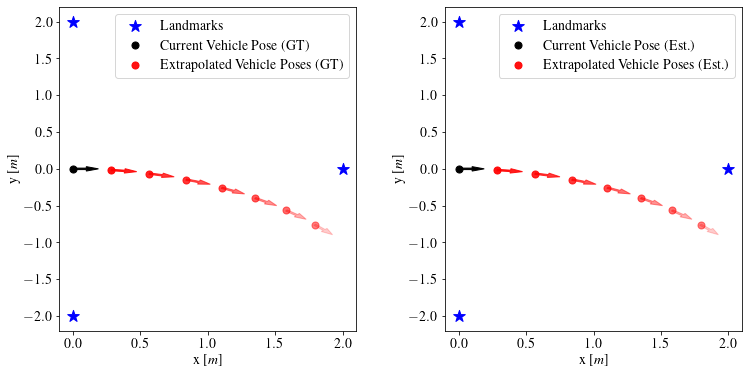

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
fig.subplots_adjust(left=0.16, right=0.95, bottom=0.2, top=0.95, wspace=0.3, hspace=0.3)

lm_ini_x = [lm[0, 0] for lm in lm_ini]
lm_ini_y = [lm[1, 0] for lm in lm_ini]

# ground truth
axs[0].scatter(lm_ini_x, lm_ini_y, marker='*', color='b', s=150, label='Landmarks')
# plot initial pose
axs[0].scatter(T_iv[0, 3], T_iv[1, 3], marker='o', color='k', s=50, label='Current Vehicle Pose (GT)')
axs[0].arrow(T_iv[0, 3], T_iv[1, 3], T_iv[0, 0]/10, T_iv[1, 0]/10, width=0.02, color='k')
for i, t in list(enumerate(np.linspace(0, 1, 8)))[1:]:
  T_vi_att = se3op.vec2tran(t * w_iv_inv) @ T_vi
  T_iv_att = npla.inv(T_vi_att)
  axs[0].scatter(T_iv_att[0, 3], T_iv_att[1, 3], marker='o', color='r', s=50, alpha=1.0 - 0.5 * t, label="Extrapolated Vehicle Poses (GT)" if i==1 else None)
  axs[0].arrow(T_iv_att[0, 3], T_iv_att[1, 3], T_iv_att[0, 0]/10, T_iv_att[1, 0]/10, width=0.02, color='r', alpha=1.0 - 0.8 * t)
axs[0].legend()
axs[0].set_xlabel('x [$m$]')
axs[0].set_ylabel('y [$m$]')

# estimated
hat_w_iv_inv = w_iv_inv_var.evaluate()
axs[1].scatter(lm_ini_x, lm_ini_y, marker='*', color='b', s=150, label='Landmarks')
# plot initial pose
axs[1].scatter(T_iv[0, 3], T_iv[1, 3], marker='o', color='k', s=50, label='Current Vehicle Pose (Est.)')
axs[1].arrow(T_iv[0, 3], T_iv[1, 3], T_iv[0, 0]/10, T_iv[1, 0]/10, width=0.02, color='k')
for i, t in list(enumerate(np.linspace(0, 1, 8)))[1:]:
  T_vi_att = se3op.vec2tran(t * hat_w_iv_inv) @ T_vi
  T_iv_att = npla.inv(T_vi_att)
  axs[1].scatter(T_iv_att[0, 3], T_iv_att[1, 3], marker='o', color='r', s=50, alpha=1.0 - 0.5 * t, label="Extrapolated Vehicle Poses (Est.)" if i==1 else None)
  axs[1].arrow(T_iv_att[0, 3], T_iv_att[1, 3], T_iv_att[0, 0]/10, T_iv_att[1, 0]/10, width=0.02, color='r', alpha=1.0 - 0.8 * t)
axs[1].legend()
axs[1].set_xlabel('x [$m$]')
axs[1].set_ylabel('y [$m$]')